### Module 4: dual simple moving average crossover strategy
---

In this module, we will prototype a trading algorithm and back test it to evaluate its potential profitability. 

The dual simple moving average crossover strategy is the equivalent of Hello World and algorithmic trading. We will use the trade logic of the simple strategy to code our algorithm in Python. We will back test this strategy using something called vectorized back testing. While it is important to back test all your trading algorithms, it is far more important to understand the limitations of back testing. We will discuss the most important pitfalls of back testing and how you can avoid them. Finally, we will discuss the next steps that you can take for improving your understanding and implementation of algorithmic trading systems.

<center><img src="../test_data/architecture_trading_algo.png" style="background-color: white" width="500" height="500"></center>


### IMPORT MODULES

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import requests
import json

/var/folders/ly/0xqts46d0xb6mpwwrttmy0tc0000gq/T/ipykernel_2196/2031113825.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### PROCESS TRADING DATA

In [3]:
from dontshare_config import ALPHA_VANTAGE_API_KEY

In [12]:
response = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey={ALPHA_VANTAGE_API_KEY}')
alphadict = json.loads(response.text)
stock = pd.DataFrame(alphadict['Time Series (Daily)']).T
stock.index = pd.to_datetime(stock.index) # convert index to datetime
stock.columns = ['open', 'high', 'low', 'close', 'volume'] # shorten column names
stock = stock.astype(float) # conver to floar
stock = stock.sort_index(ascending=True) # order in timeline manner, past to future
stock

,open,high,low,close,volume
2023-03-21,274.880,275.0000,269.5191,273.78,34558704.0
2023-03-22,273.400,281.0400,272.1800,272.29,34873330.0
2023-03-23,277.940,281.0600,275.2000,277.66,36610879.0
2023-03-24,277.240,280.6300,275.2800,280.57,28199962.0
2023-03-27,280.500,281.4589,275.5200,276.38,26840212.0
...,...,...,...,...,...
2023-08-07,328.370,331.1100,327.5200,330.11,17741526.0
2023-08-08,326.960,328.7500,323.0000,326.05,22327574.0
2023-08-09,326.470,327.1100,321.0499,322.23,22373268.0
2023-08-10,326.015,328.2600,321.1800,322.93,20113725.0


### GENERATE TRADING SIGNAL

              open      high       low   close      volume  SMA_10d  SMA_20d
2023-03-21  274.88  275.0000  269.5191  273.78  34558704.0      NaN      NaN
2023-03-22  273.40  281.0400  272.1800  272.29  34873330.0      NaN      NaN
2023-03-23  277.94  281.0600  275.2000  277.66  36610879.0      NaN      NaN
2023-03-24  277.24  280.6300  275.2800  280.57  28199962.0      NaN      NaN
2023-03-27  280.50  281.4589  275.5200  276.38  26840212.0      NaN      NaN


<Axes: >

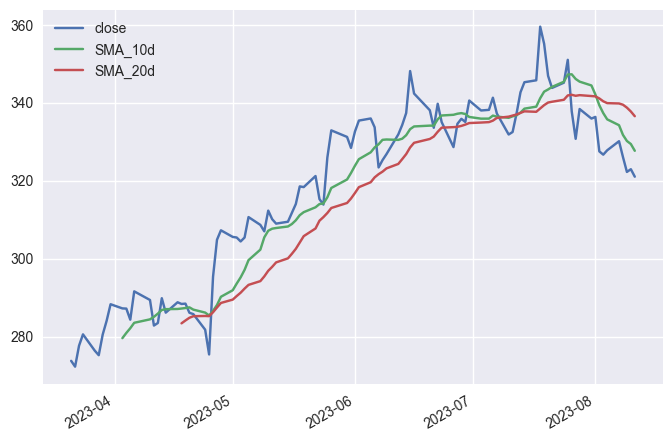

In [17]:
# adding SMAs to stock data
stock['SMA_10d'] = stock['close'].rolling(10).mean()
stock['SMA_20d'] = stock['close'].rolling(20).mean()
print(stock.head())
stock[['close','SMA_10d','SMA_20d']].plot()

<Axes: >

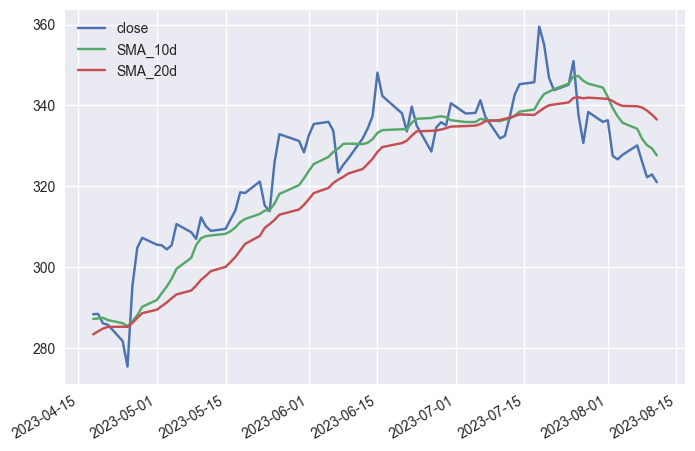

In [18]:
# We need to remove missingness
stock = stock.dropna()
stock[['close','SMA_10d','SMA_20d']].plot()

In [25]:
signal = pd.DataFrame()
signal['crossover'] = stock['SMA_10d'] - stock['SMA_20d']
signal['close-close'] = stock['close'].diff()
signal.dropna(inplace=True) # we need to get rid of missingness

### VECTORIZED BACKTESTING

In [26]:
stock['position'] = np.where(stock['SMA_10d'] > stock['SMA_20d'], 1, -1)
stock['returns'] = np.log(stock['close']/stock['close'].shift(1))
stock['strategy'] = stock['position'].shift(1) * stock['returns']
stock = stock.dropna()
stock.head()

/var/folders/ly/0xqts46d0xb6mpwwrttmy0tc0000gq/T/ipykernel_2196/954363919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['position'] = np.where(stock['SMA_10d'] > stock['SMA_20d'], 1, -1)
/var/folders/ly/0xqts46d0xb6mpwwrttmy0tc0000gq/T/ipykernel_2196/954363919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['returns'] = np.log(stock['close']/stock['close'].shift(1))
/var/folders/ly/0xqts46d0xb6mpwwrttmy0tc0000gq/T/ipykernel_2196/954363919.py:3: SettingWithCopyWarning: 
A value is tryin

,open,high,low,close,volume,SMA_10d,SMA_20d,position,returns,strategy
2023-04-20,285.25,289.03,285.0800,286.11,23244363.0,287.502,284.8235,1,-0.008145,-0.008145
2023-04-21,285.01,286.27,283.0608,285.76,21676387.0,286.918,285.2285,1,-0.001224,-0.001224
2023-04-24,282.09,284.95,278.7200,281.77,26611014.0,286.156,285.2885,1,-0.014061,-0.014061
2023-04-25,279.51,281.60,275.3700,275.42,45772236.0,285.415,285.2405,1,-0.022794,-0.022794
2023-04-26,296.70,299.57,292.7300,295.37,64481117.0,286.603,286.2475,1,0.069932,0.069932


### EVALUATE PERFORMANCE

<Axes: >

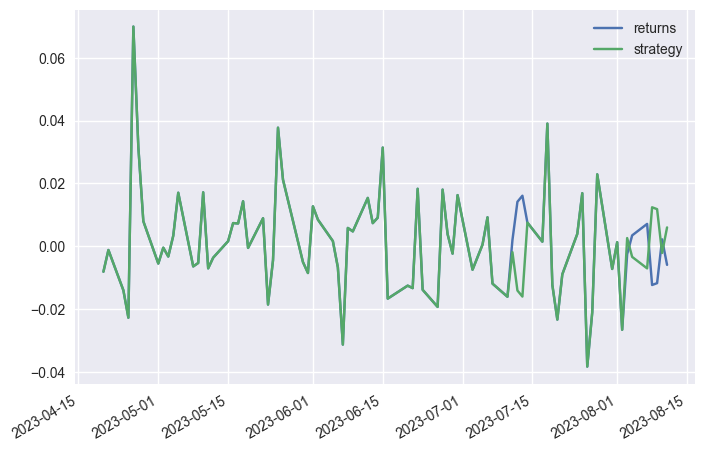

In [29]:
stock[['returns', 'strategy']].plot()

In [30]:
np.exp(stock[['returns', 'strategy']].sum())

returns     1.112879
strategy    1.086270
dtype: float64

In [35]:
stock[['returns', 'strategy']].describe()

,returns,strategy
count,79.000000,79.000000
mean,0.001354,0.001047
std,0.016855,0.016878
min,-0.038364,-0.038364
25%,-0.008348,-0.008348
50%,0.001250,-0.000491
75%,0.008982,0.008982
max,0.069932,0.069932


### SUMMARY 
---

**Lecture Summary: Backtesting Trading Algorithms**

In this lecture, the focus is on the process of backtesting trading algorithms, examining the creation and evaluation of a trading strategy using historical data. The lecture covers the steps involved in building a trading algorithm and discusses the concept of vectorized backtesting. Vectorization is a powerful technique in Python for optimizing code using libraries like numpy and pandas, which eliminates the need for explicit loops and simplifies complex operations.

The process of building and evaluating the trading algorithm involves the following steps and concepts:

1. **Algorithm Creation:**
   - Import necessary modules.
   - Process trading data using techniques like calculating moving averages.
   - Generate trading signals based on certain conditions, such as using a 10-day and 20-day simple moving average crossover.

2. **Vectorized Backtesting:**
   - Vectorization technique, employed via numpy and pandas, helps eliminate explicit loops and streamline code.
   - Create a position column in a pandas DataFrame using a single line of code that utilizes conditions based on moving average crossovers. Positions are assigned values of 1 for long and -1 for short.
   - Calculate log returns based on the position using the log method. Log returns simplify the code and allow for addition of returns instead of complex multiplications.
   - Construct a strategy column by multiplying positions with corresponding returns. This captures profit/loss based on the trading strategy.

3. **Comparison of Strategies:**
   - Analyze the performance of the dual moving average crossover strategy against a basic long-only strategy.
   - Plot and compare returns for both strategies, showcasing how the dual strategy performs when going short based on signals.
   - Convert log returns back to regular returns using the exponential function and the sum method.

4. **Performance Assessment and Challenges:**
   - Assess the strategy's performance by comparing returns to the basic long-only strategy.
   - Consideration of potential issues, such as underperformance of the strategy, which could arise from poor signal quality or overfitting to specific data.
   - Indication that further optimization might be necessary, potentially involving different moving averages or improved signals.

The lecture highlights the complexities and challenges of backtesting trading strategies, emphasizing the need to critically evaluate results and consider potential pitfalls. The possibility of overfitting to historical data and the importance of robust signal generation are both highlighted as areas for further exploration and improvement.